### 298A Ensemble Model of Random Forests for Feature Selection

### 3 targets
1. LMP_Norm
2. PV_kwAC_out_Norm
3. Community_Load

In [1]:
# Import libraries and suppress warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.feature_selection import SelectFromModel

import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [2]:
# Create function to calculate Symmetric Mean Absolute Percentage Error (SMAPE)

def smape(y_true, y_pred):                                 # calc score between two pandas dataframes as parameters
    y_true = np.array(y_true)                              # covert to np array
    y_pred = np.array(y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2    
    numerator   = np.abs(y_true - y_pred)
    return np.mean(numerator / denominator) * 100          # return SMAPE as float

In [3]:
# Load the data into a pandas DataFrame
df = pd.read_csv('data_processed.csv', index_col='Time')

In [4]:
# Explore dataset
# print(df.describe())
# df.info()

In [5]:
# drop columns with previously identified zero values / variation from pre-processing work
df = df.drop('Regulation Down Total (MW)', axis=1)  # updated 4/27/23 from 'Regulation Mileage Down Total (MW)' to 'Regulation Down Total (MW)'
df = df.drop('Regulation Up Total (MW)', axis=1)    # updated 4/27/23 from 'Regulation Mileage Up Total (MW)' to 'Regulation Up Total (MW)'

In [6]:
# Check for nulls
df.isnull().sum()

Load                                0
Non-Spinning Reserves Total (MW)    0
Total Volume(MW)                    0
Load_Forecast_Norm                  0
Solar                               0
Wind                                0
Geothermal                          0
Biomass                             0
Biogas                              0
Small Hydro                         0
Coal                                0
Nuclear                             0
Natural Gas                         0
Large Hydro                         0
Batteries                           0
Imports                             0
Gas Price                           0
GHG Allowance Price                 0
Energy_Norm                         0
Congestion_Norm                     0
Loss_Norm                           0
solar_local_Curtailment Type        0
solar_local_Curtailment (MWh)       0
solar_local_Curtailment (MW)        0
solar_system_Curtailment (MWh)      0
solar_system_Curtailment (MW)       0
wind_local_C

<AxesSubplot:>

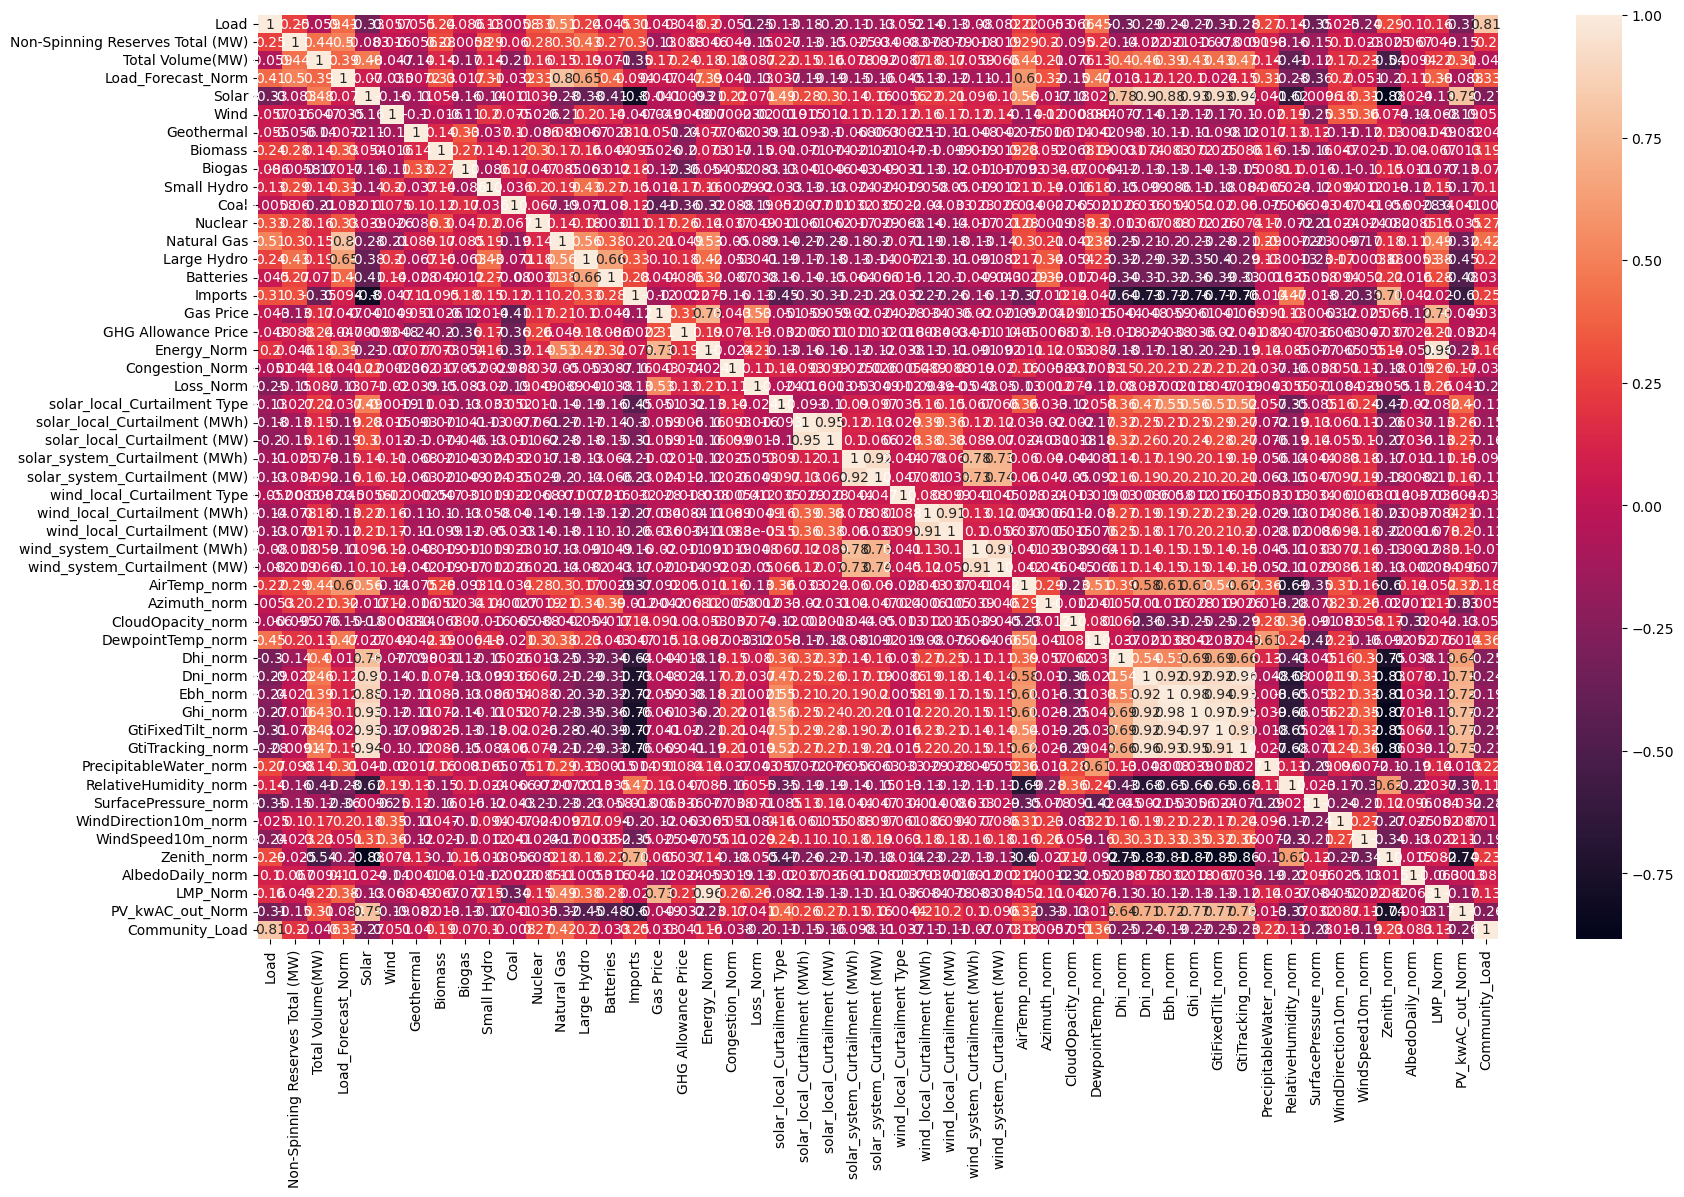

In [7]:
# Visualize correlations between all features of original dataset
plt.figure(figsize=(20,12))
sns.heatmap(df.corr(), annot=True)

In [8]:
# Split the data that is not feature reduced into 80/20 training and testing sets with 3 targets
X_train, X_test, y_train, y_test = train_test_split(df.drop(['LMP_Norm','PV_kwAC_out_Norm','Community_Load'], axis=1), df.loc[:,['LMP_Norm','PV_kwAC_out_Norm','Community_Load']], test_size=0.2, random_state=42)

In [59]:
%%time

# Train the ensemble model on the training set [NO Feature Reduction; FULL dataset]
rf = RandomForestRegressor(n_estimators=100, criterion='squared_error', max_depth=3, random_state=42)

# Create Multi-output regressor
multi_output_regressor = MultiOutputRegressor(rf)

# Train/fit model
multi_output_regressor.fit(X_train, y_train)       # multi target

# Get the feature importances of each feature in the ensemble model
feature_importances = np.mean([estimator.feature_importances_ for estimator in multi_output_regressor.estimators_], axis=0)

# make prediction on model test data                   
y_pred = multi_output_regressor.predict(X_test)    # multi target

# calculate MSE of new model
mse = mean_squared_error(y_test, y_pred)

# calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# calculate SMAPE
smape_score = smape(y_test, y_pred)

# Evaluate the performance of the model on the test set 
# NOTE accuracy is not a good metric for multi-output regressor model; accuracy is best for classification
print('MSE:  {:.2f}'.format(mse))
print()
print('RMSE: {:.2f}'.format(rmse))
print()
print('estimator (e): 100')
print('criterion (c): squared_error')
print('max depth (m): 3')

MSE:  0.01

RMSE: 0.08

estimator (e): 100
criterion (c): squared_error
max depth (m): 3
CPU times: user 26.9 s, sys: 223 ms, total: 27.1 s
Wall time: 28.5 s


In [10]:
# Sort the feature importances in descending order to get a ranked list of the most important features
importance = pd.DataFrame(feature_importances, index=X_train.columns, columns=['importance'])
importance = importance.sort_values('importance', ascending=False)        # Set to True for better visual
importance['std'] = X_train.std()
importance

importance       std
Load                                0.333352  0.098171
Energy_Norm                         0.319489  0.050245
Solar                               0.241709  0.343297
Azimuth_norm                        0.062338  0.284913
GtiFixedTilt_norm                   0.021491  0.317416
GtiTracking_norm                    0.006859  0.366439
Natural Gas                         0.006162  0.153323
Congestion_Norm                     0.003726  0.017246
Load_Forecast_Norm                  0.001994  0.138579
RelativeHumidity_norm               0.000644  0.213151
Zenith_norm                         0.000489  0.248985
Ghi_norm                            0.000432  0.300008
solar_system_Curtailment (MWh)      0.000387  0.044049
Imports                             0.000199  0.185381
Large Hydro                         0.000173  0.163068
CloudOpacity_norm                   0.000099  0.194957
Biomass                             0.000067  0.104148
Geothermal                          0.000050  0.067274
Gas Price                           0.000046  0.102713
WindDirection10m_norm               0.000044  0.260118
Nuclear                             0.000043  0.214543
Loss_Norm                           0.000034  0.032739
Small Hydro                         0.000032  0.023793
Batteries                           0.000030  0.106228
DewpointTemp_norm                   0.000029  0.145928
PrecipitableWater_norm              0.000026  0.161683
Non-Spinning Reserves Total (MW)    0.000025  0.110186
solar_system_Curtailment (MW)       0.000019  0.054457
WindSpeed10m_norm                   0.000014  0.123117
Dni_norm                            0.000000  0.361289
Wind                                0.000000  0.222997
Biogas                              0.000000  0.060029
SurfacePressure_norm                0.000000  0.151284
Ebh_norm                            0.000000  0.280254
Total Volume(MW)                    0.000000  0.103625
wind_system_Curtailment (MW)        0.000000  0.043279
Dhi_norm                            0.000000  0.144055
AirTemp_norm                        0.000000  0.152407
wind_system_Curtailment (MWh)       0.000000  0.034265
wind_local_Curtailment (MW)         0.000000  0.064432
wind_local_Curtailment (MWh)        0.000000  0.057305
wind_local_Curtailment Type         0.000000  0.076728
solar_local_Curtailment (MW)        0.000000  0.086986
solar_local_Curtailment (MWh)       0.000000  0.073455
solar_local_Curtailment Type        0.000000  0.323640
Coal                                0.000000  0.171734
GHG Allowance Price                 0.000000  0.275681
AlbedoDaily_norm                    0.000000  0.160593

## Test Model Based on Feature Selection Tuning: 
1. threshold (0.5, median) - parameter [median best b/c more closely matches data fit vs 1/2 cutoff]

In [11]:
%%time

""" 
Select most relevant features and retrain model 
Create list of 5 most influencial features for each target
Review most impactful for each target to create df of 15 most impactful features 
Pass to next model in CAISO chain
 """

selected = []

for i in range(3):   
    """ loop through for 3 target variables """
    # Select a subset of the most important features based on a predetermined threshold or using feature selection techniques
    selector = SelectFromModel(multi_output_regressor.estimators_[i], threshold='median', max_features=5, prefit=True) 
    X_train_new = selector.transform(X_train)
    X_test_new  = selector.transform(X_test)
    # print(selector.get_support())

    # Get the boolean mask of selected features and the names of the original columns
    selected_mask          = selector.get_support()
    original_feature_names = X_train.columns.tolist() 

    # Use the boolean mask to filter the column names to only the selected ones
    selected_feature_num = [original_feature_names[i] for i in range(len(original_feature_names)) if selected_mask[i]]

    # Print the selected feature names
    print('Target: ' + y_train.columns[i])
    print('Selected features:', selected_feature_num)
    selected += selected_feature_num
    
    # Train a new model using the selected subset of features on the training set
    rf_new = RandomForestRegressor(n_estimators=100, criterion='squared_error', max_depth=3, random_state=42)
    rf_new.fit(X_train_new, y_train)

    # Create Multi-output regressor
    multi_output_regressor_new = MultiOutputRegressor(rf_new)

    # Train/fit model
    multi_output_regressor_new.fit(X_train_new, y_train)       # multi target
    
    # make prediction on new model test data
    y_pred_new = multi_output_regressor_new.predict(X_test_new)

    # calculate MAE of new model
    mse = mean_squared_error(y_test, y_pred_new)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_new))
    
    # calculate SMAPE
    #smape_score = smape(y_test, y_pred_new)

    # Evaluate the performance of the model on the test set 
    # NOTE accuracy is not a good metric for multi-output regressor model
    print('MSE:    {:.2f}'.format(mse))
    print('RMSE:   {:.2f}'.format(rmse))
    #print('sMAPE:  {:.2f}'.format(smape_score))
    print()

Target: LMP_Norm
Selected features: ['Load_Forecast_Norm', 'Natural Gas', 'Energy_Norm', 'Congestion_Norm', 'RelativeHumidity_norm']
MSE:    0.02
RMSE:   0.15

Target: PV_kwAC_out_Norm
Selected features: ['Solar', 'Azimuth_norm', 'GtiFixedTilt_norm', 'GtiTracking_norm', 'Zenith_norm']
MSE:    0.01
RMSE:   0.10

Target: Community_Load
Selected features: ['Load', 'Non-Spinning Reserves Total (MW)', 'Total Volume(MW)', 'Load_Forecast_Norm', 'Solar']
MSE:    0.01
RMSE:   0.11

CPU times: user 18.9 s, sys: 165 ms, total: 19.1 s
Wall time: 19.6 s


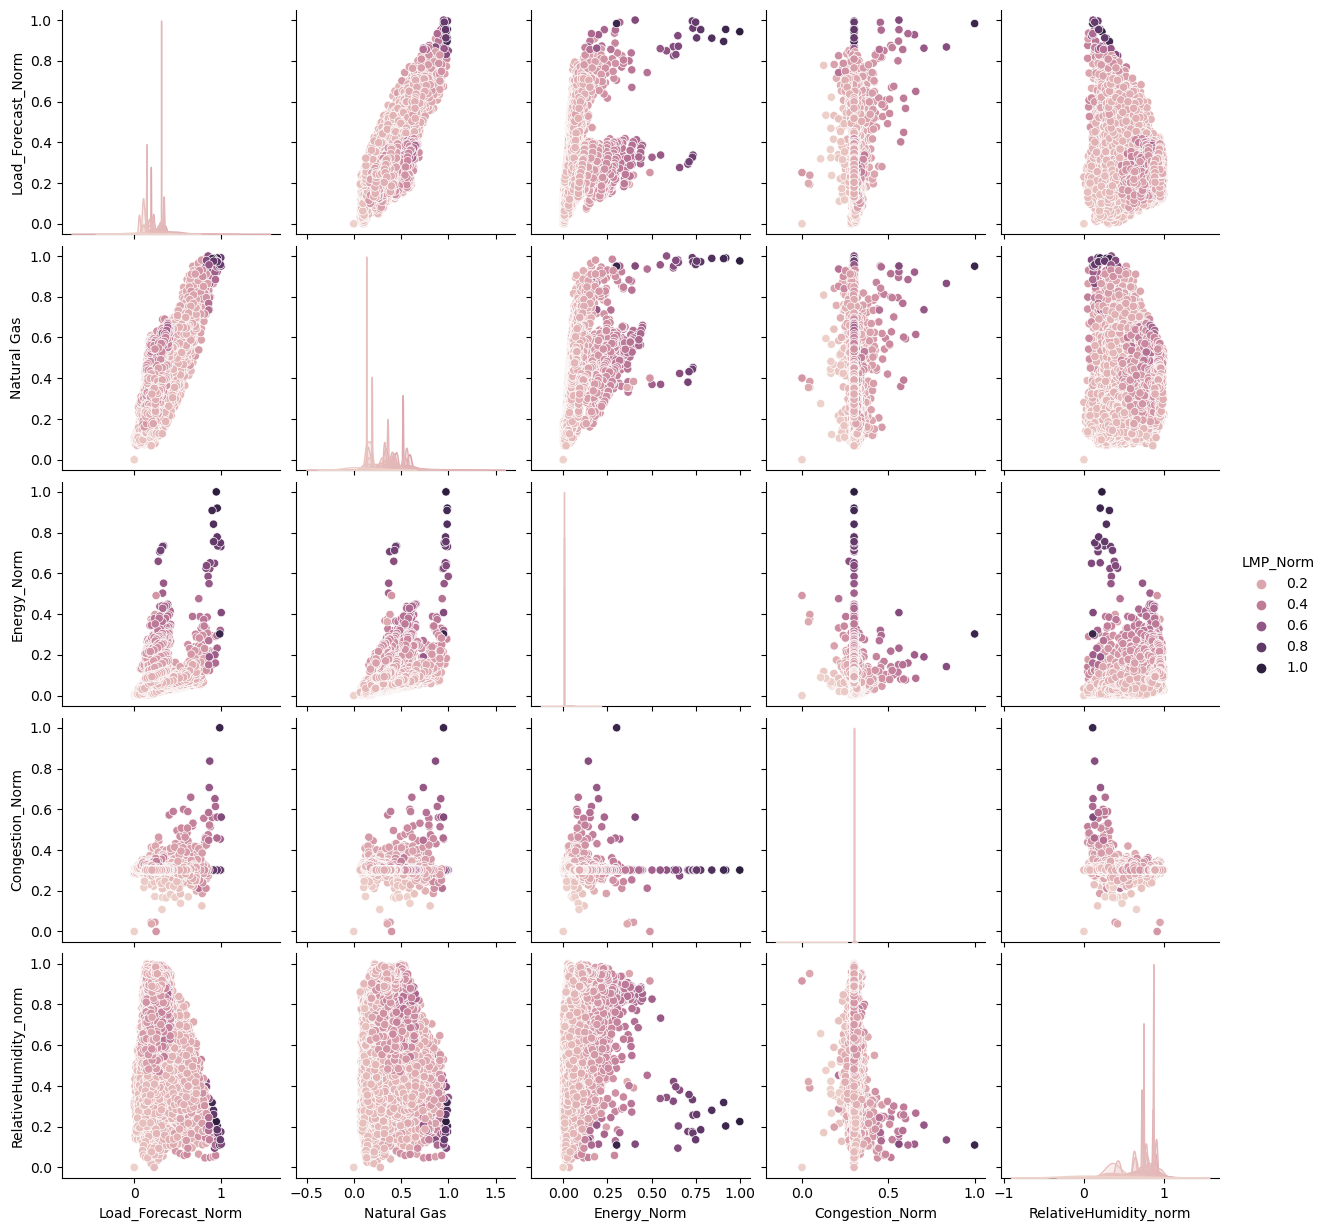

In [12]:
# Visualize relationship of top 5 features for 1st target variable
sns.pairplot(df, hue='LMP_Norm', vars=['Load_Forecast_Norm', 'Natural Gas', 'Energy_Norm', 'Congestion_Norm', 'RelativeHumidity_norm'])

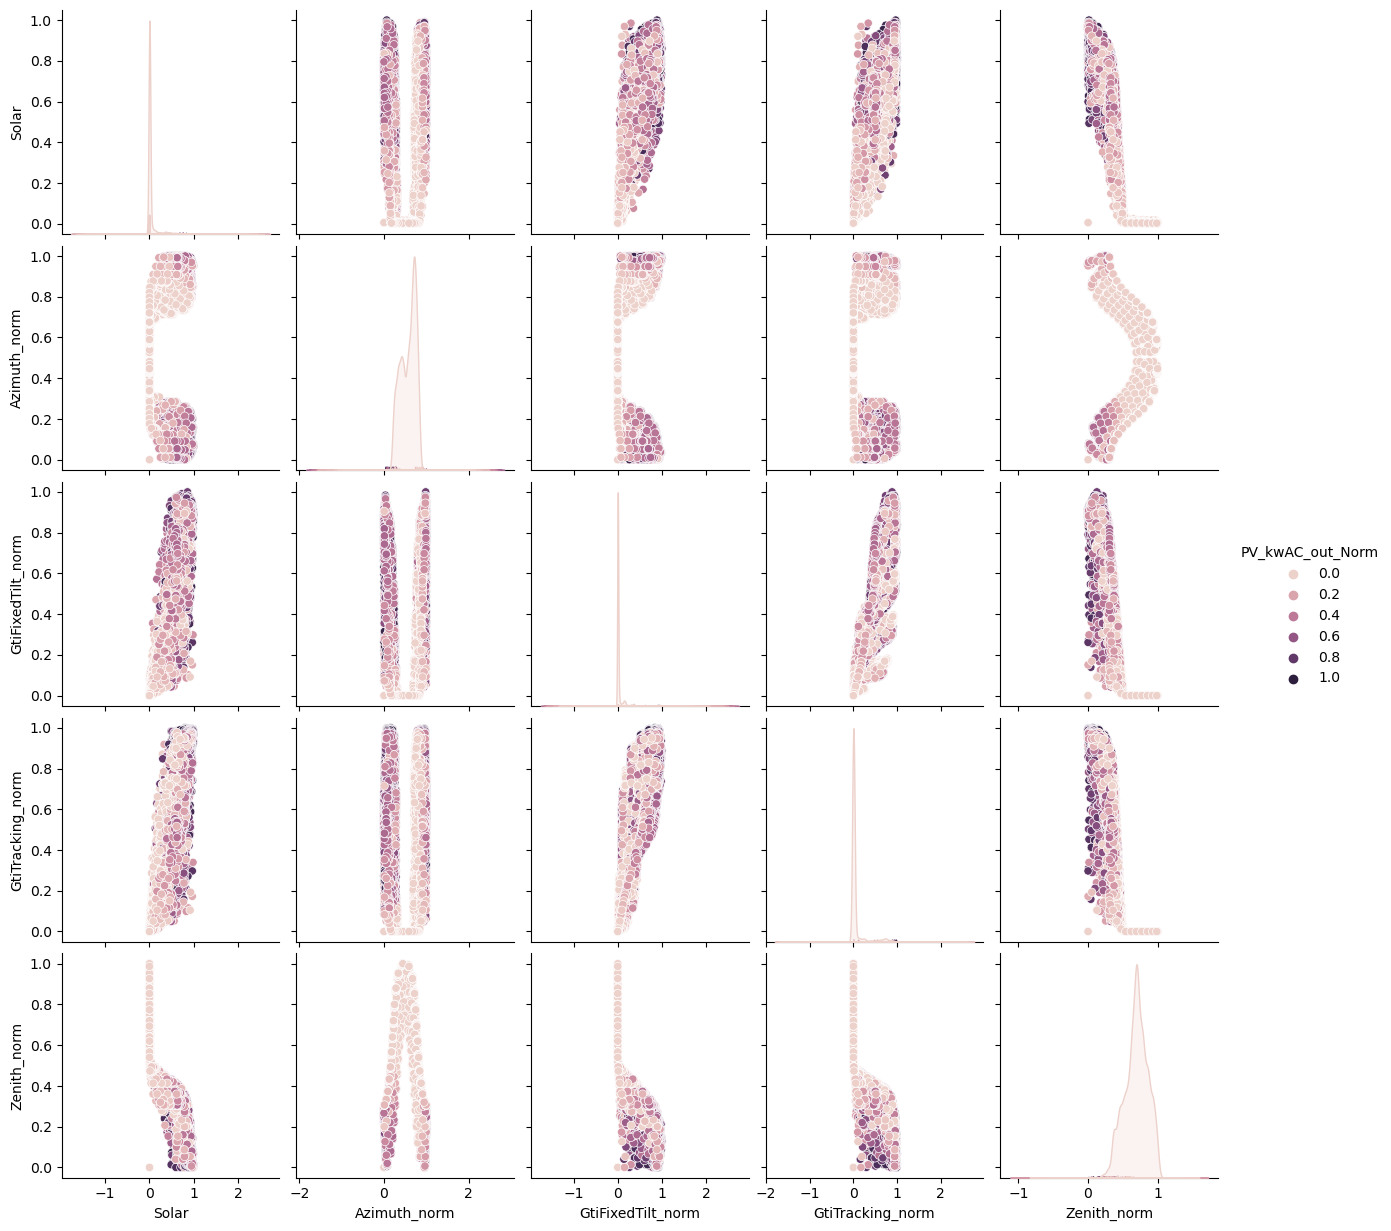

In [13]:
# Visualize relationship of top 5 features for 2nd target variable
sns.pairplot(df, hue='PV_kwAC_out_Norm', vars=['Solar', 'Azimuth_norm', 'GtiFixedTilt_norm', 'GtiTracking_norm', 'Zenith_norm'])

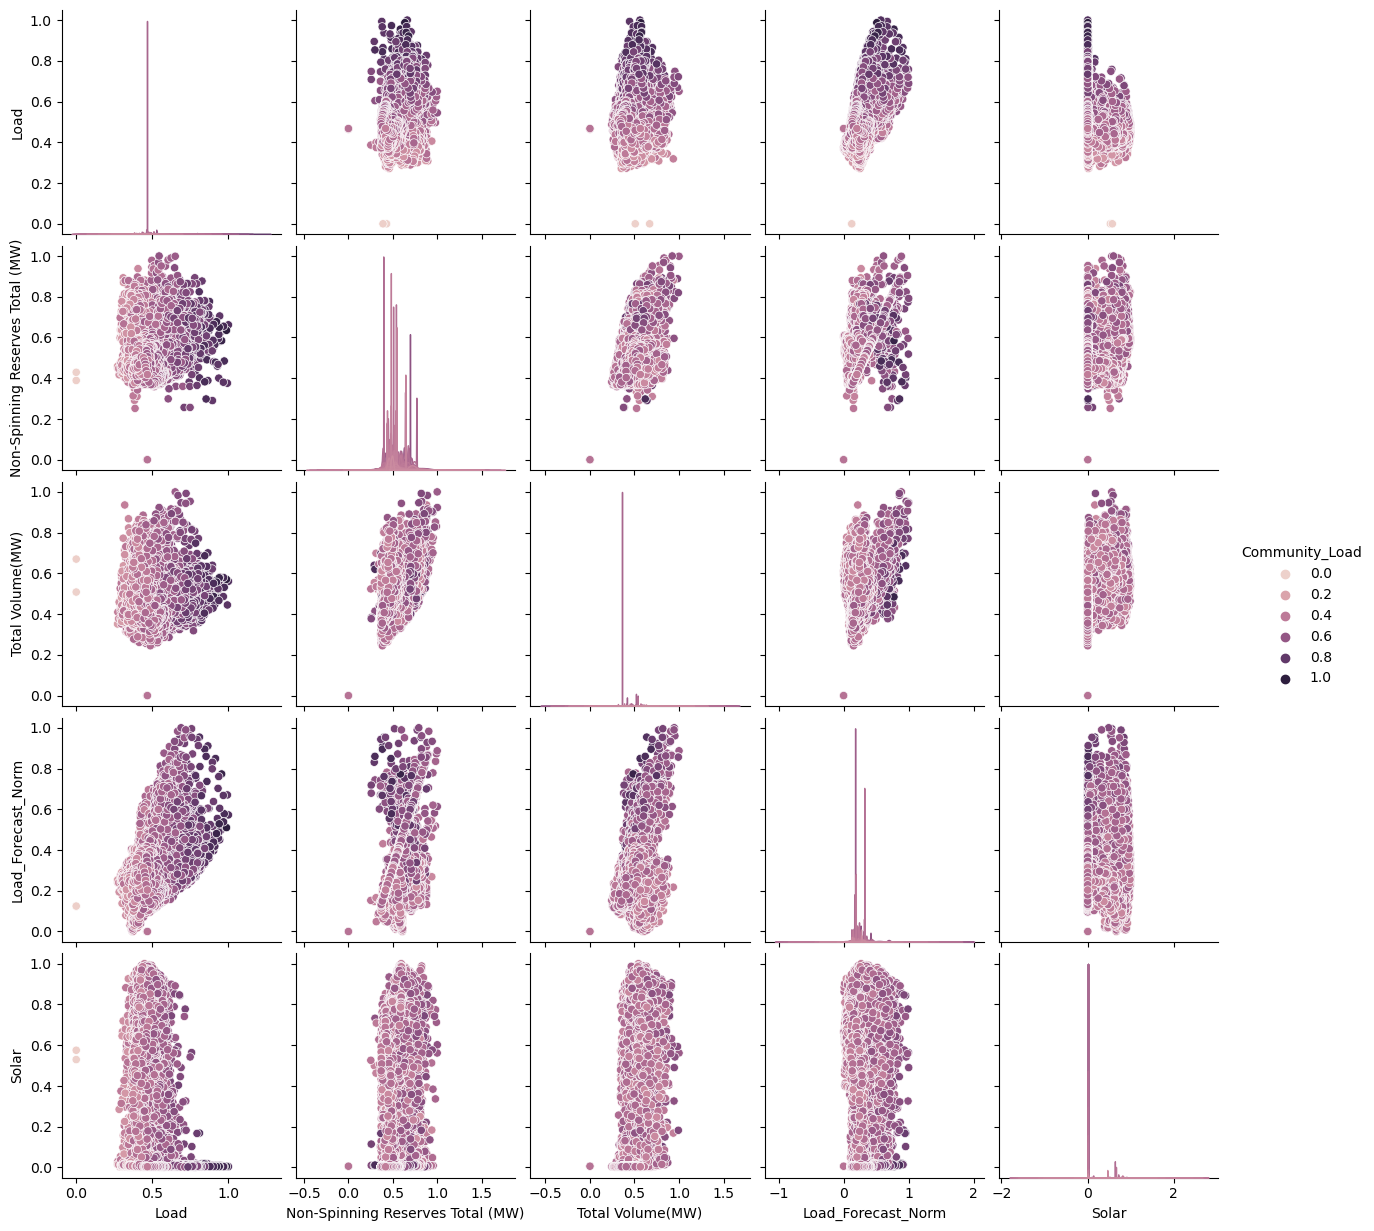

In [14]:
# Visualize relationship of top 5 features for 3rd target variable
sns.pairplot(df, hue='Community_Load', vars=['Load', 'Non-Spinning Reserves Total (MW)', 'Total Volume(MW)', 'Load_Forecast_Norm', 'Solar'])

### 

## Metrics: Selected Features

In [15]:
""" 
Note and remove duplicates (e.g. Solar & Load_Forecast_Norm)
Include next two features with highest importance from two full set that were not included 
These are: Ghi_norm & solar_system_Curtailment (MWh) 
This creates a dataset of the 15 most relevant features
"""

df_select = df.loc[:,['Load_Forecast_Norm','Natural Gas','Energy_Norm','Congestion_Norm','RelativeHumidity_norm','Solar','Azimuth_norm','GtiFixedTilt_norm',
 'GtiTracking_norm','Zenith_norm','Load','Non-Spinning Reserves Total (MW)','Total Volume(MW)', 'Ghi_norm', 'solar_system_Curtailment (MWh)', 'LMP_Norm','PV_kwAC_out_Norm','Community_Load']]
#df_select.info()

In [16]:
# Save dataframe to CSV file for use by next model in chain
df_select.to_csv('ensemble_out.csv', index=True)

In [17]:
# Retest model with smaller dataset. Split the data into 80/20 training and testing sets with 3 targets
X_train_select, X_test_select, y_train_select, y_test_select = train_test_split(df_select.drop(['LMP_Norm','PV_kwAC_out_Norm','Community_Load'], axis=1), df_select.loc[:,['LMP_Norm','PV_kwAC_out_Norm','Community_Load']], test_size=0.2, random_state=42)

In [18]:
%%time

# Train the ensemble model on the training set
rf_select = RandomForestRegressor(n_estimators=100, criterion='squared_error', max_depth=3, random_state=42)

# Create Multi-output regressor
multi_output_regressor_select = MultiOutputRegressor(rf_select)

# Train/fit model
multi_output_regressor_select.fit(X_train_select, y_train_select)       # multi target

# Get the feature importances of each feature in the ensemble model
feature_importances_select = np.mean([estimator.feature_importances_ for estimator in multi_output_regressor_select.estimators_], axis=0)

# Sort the feature importances in descending order to get a ranked list of the most important features
importance_select = pd.DataFrame(feature_importances_select, index=X_train_select.columns, columns=['importance'])
importance_select = importance_select.sort_values('importance', ascending=False)        # Set to True for better visual
importance_select['std'] = X_train_select.std()

# make prediction on model test data                   
y_pred_select = multi_output_regressor_select.predict(X_test_select)    # multi target

# calculate MSE of new model
mse_select = mean_squared_error(y_test_select, y_pred_select)

# calculate RMSE
rmse_select = np.sqrt(mean_squared_error(y_test_select, y_pred_select))

# calculate SMAPE
smape_score_select = smape(y_test_select, y_pred_select)

# Evaluate the performance of the model on the test set 
# NOTE accuracy is not a good metric for multi-output regressor model; accuracy best for classification
print('RMSE: {:.2f}'.format(rmse_select))
print('MSE:  {:.2f}'.format(mse_select))

RMSE: 0.08
MSE:  0.01
sMAPE:47.26
CPU times: user 10.2 s, sys: 43.4 ms, total: 10.2 s
Wall time: 10.6 s


In [19]:
importance_select

importance       std
Load                                0.333355  0.098171
Energy_Norm                         0.319951  0.050245
Solar                               0.241727  0.343297
Azimuth_norm                        0.062338  0.284913
GtiFixedTilt_norm                   0.021491  0.317416
GtiTracking_norm                    0.006896  0.366439
Natural Gas                         0.006165  0.153323
Congestion_Norm                     0.003727  0.017246
Load_Forecast_Norm                  0.002016  0.138579
RelativeHumidity_norm               0.000941  0.213151
Zenith_norm                         0.000489  0.248985
solar_system_Curtailment (MWh)      0.000426  0.044049
Ghi_norm                            0.000416  0.300008
Non-Spinning Reserves Total (MW)    0.000062  0.110186
Total Volume(MW)                    0.000000  0.103625

### Visuals: Selected Features

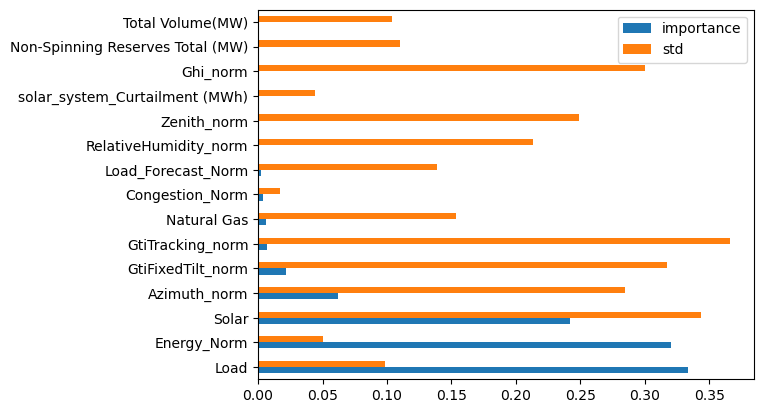

In [20]:
ax = importance_select.plot(kind='barh', legend=True)

# Tuning Model After Experimentation and Feature Selection

## Model ingesting selected features [Max Depth Tuning]
1. estimators (100, 160) - hyperparameter
2. criterion (squared_error, absolute_error) - parameter
3. max_depth (3, 5, 10) - hyperparameter

In [21]:
### Programatic Tune

def tune(e,c,m):
    e = int(e)
    m = int(m)

    # Train the ensemble model on the training set
    rf_select = RandomForestRegressor(n_estimators=e, criterion=c, max_depth=m, random_state=42)

    # Create Multi-output regressor
    multi_output_regressor_select = MultiOutputRegressor(rf_select)

    # Train/fit model
    multi_output_regressor_select.fit(X_train_select, y_train_select)       # multi target

    # Get the feature importances of each feature in the ensemble model
    feature_importances_select = np.mean([estimator.feature_importances_ for estimator in multi_output_regressor_select.estimators_], axis=0)

    # Sort the feature importances in descending order to get a ranked list of the most important features
    importance_select = pd.DataFrame(feature_importances_select, index=X_train_select.columns, columns=['importance'])
    importance_select = importance_select.sort_values('importance', ascending=False)        # Set to True for better visual
    importance_select['std'] = X_train_select.std()

    # make prediction on model test data                   
    y_pred_select = multi_output_regressor_select.predict(X_test_select)    # multi target

    # calculate MSE of new model
    mse_select = mean_squared_error(y_test_select, y_pred_select)
    
    # calculate MAE of new model
    mae_select = mean_absolute_error(y_test_select, y_pred_select)

    # calculate RMSE
    rmse_select = np.sqrt(mean_squared_error(y_test_select, y_pred_select))

    # calculate SMAPE
    smape_score_select = smape(y_test_select, y_pred_select)

    # Evaluate the performance of the model on the test set 
    # NOTE accuracy is not a good metric for multi-output regressor model
    print('MSE:  {:.2f}'.format(mse_select))
    print('MAE:  {:.2f}'.format(mae_select))
    print('RMSE: {:.2f}'.format(rmse_select))
    print('sMAPE:{:.2f}'.format(smape_score_select))
    pass

In [22]:
import time

e = [100,160]
c = ['squared_error', 'absolute_error']
m = [3,5,10]

for i in e:
    for ii in c:
        for iii in m:
            start_time = time.time()
            tune(i,ii,iii)
            end_time = time.time()
            
            elapsed_time = end_time - start_time
            print('estimator (e): {}'.format(str(i)))
            print('criterion (c): {}'.format(ii))
            print('max depth (m): {}'.format(str(iii)))
            print('time         : {:.2f} seconds'.format(elapsed_time))
            print()

MSE:  0.01
MAE:  0.05
RMSE: 0.08
sMAPE:47.26
estimator (e): 100
criterion (c): squared_error
max depth (m): 3
time         : 9.52 seconds

MSE:  0.01
MAE:  0.04
RMSE: 0.07
sMAPE:45.11
estimator (e): 100
criterion (c): squared_error
max depth (m): 5
time         : 16.45 seconds

MSE:  0.00
MAE:  0.04
RMSE: 0.07
sMAPE:43.39
estimator (e): 100
criterion (c): squared_error
max depth (m): 10
time         : 29.11 seconds

MSE:  0.01
MAE:  0.04
RMSE: 0.09
sMAPE:nan
estimator (e): 100
criterion (c): absolute_error
max depth (m): 3
time         : 1694.97 seconds

MSE:  0.01
MAE:  0.04
RMSE: 0.08
sMAPE:nan
estimator (e): 100
criterion (c): absolute_error
max depth (m): 5
time         : 2049.73 seconds

MSE:  0.01
MAE:  0.04
RMSE: 0.07
sMAPE:nan
estimator (e): 100
criterion (c): absolute_error
max depth (m): 10
time         : 2894.65 seconds

MSE:  0.01
MAE:  0.05
RMSE: 0.08
sMAPE:47.27
estimator (e): 160
criterion (c): squared_error
max depth (m): 3
time         : 17.95 seconds

MSE:  0.01
MAE: 

## Model ingesting selected features [No Max Depth]
1. estimators (100, 160) - hyperparameter
2. criterion (squared_error, absolute_error) - parameter
3. max_depth (None) <<< hard coded by removing hyperparameter >>>

In [23]:
### Programatic Tune

def tune_no_max(e,c):
    e = int(e)

    # Train the ensemble model on the training set
    rf_select = RandomForestRegressor(n_estimators=e, criterion=c, random_state=42)

    # Create Multi-output regressor
    multi_output_regressor_select = MultiOutputRegressor(rf_select)

    # Train/fit model
    multi_output_regressor_select.fit(X_train_select, y_train_select)       # multi target

    # Get the feature importances of each feature in the ensemble model
    feature_importances_select = np.mean([estimator.feature_importances_ for estimator in multi_output_regressor_select.estimators_], axis=0)

    # Sort the feature importances in descending order to get a ranked list of the most important features
    importance_select = pd.DataFrame(feature_importances_select, index=X_train_select.columns, columns=['importance'])
    importance_select = importance_select.sort_values('importance', ascending=False)        # Set to True for better visual
    importance_select['std'] = X_train_select.std()

    # make prediction on model test data                   
    y_pred_select = multi_output_regressor_select.predict(X_test_select)    # multi target

    # calculate MSE of new model
    mse_select = mean_squared_error(y_test_select, y_pred_select)
    
    # calculate MAE of new model
    mae_select = mean_absolute_error(y_test_select, y_pred_select)

    # calculate RMSE
    rmse_select = np.sqrt(mean_squared_error(y_test_select, y_pred_select))

    # calculate SMAPE
    smape_score_select = smape(y_test_select, y_pred_select)

    # Evaluate the performance of the model on the test set 
    # NOTE accuracy is not a good metric for multi-output regressor model
    print('MSE:  {:.2f}'.format(mse_select))
    print('MAE:  {:.2f}'.format(mae_select))
    print('RMSE: {:.2f}'.format(rmse_select))
    print('sMAPE:{:.2f}'.format(smape_score_select))
    pass

In [24]:
import time

e = [100,160]
c = ['squared_error', 'absolute_error']

for i in e:
    for ii in c:
        start_time = time.time()
        tune_no_max(i,ii)
        end_time = time.time()
            
        elapsed_time = end_time - start_time
        print('estimator (e): {}'.format(str(i)))
        print('criterion (c): {}'.format(ii))
        print('max depth (m): None')
        print('time         : {:.2f} seconds'.format(elapsed_time))
        print()

MSE:  0.00
MAE:  0.03
RMSE: 0.07
sMAPE:nan
estimator (e): 100
criterion (c): squared_error
max depth (m): None
time         : 46.30 seconds

MSE:  0.00
MAE:  0.04
RMSE: 0.07
sMAPE:nan
estimator (e): 100
criterion (c): absolute_error
max depth (m): None
time         : 4076.81 seconds

MSE:  0.00
MAE:  0.03
RMSE: 0.07
sMAPE:nan
estimator (e): 160
criterion (c): squared_error
max depth (m): None
time         : 72.41 seconds

MSE:  0.00
MAE:  0.04
RMSE: 0.07
sMAPE:nan
estimator (e): 160
criterion (c): absolute_error
max depth (m): None
time         : 6700.34 seconds



# Analysis 
By focusing on the most important features, the ensemble model performs similarly regardless of the dataset size. Therefore processing down the datasize to improve computational capability and speed is feasible. 

A 15 feature dataset; 14 influencing features on 1 target variable, performs well for predicting locational marginal pricing (LMP_Norm), demand (Community_Load), and generation (PV_kwAC_out_Norm) for CAISO energy users.

Squared Error criterion with 100 estimators, set to 5 to 10 max depth, performs well fastest. Removing the max depth hyperparameter slightly improve error performance by 1%; however, deminishes computational performance by adding more than 71% additional time. 

Due to the fact that the CAISO prediction is day-ahead and only needs to be trained once per day, the additional computation time is palletable; however, the benefit is marginal.

## Comparing Feature SELECTED Dataset Random Forest and MultiOut Regressor

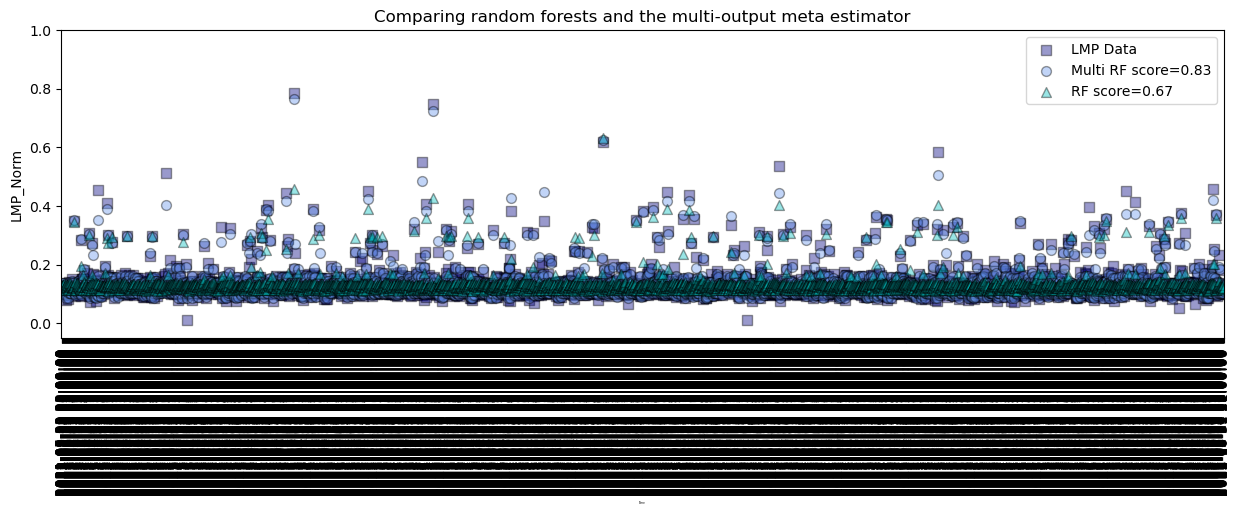

In [84]:
# scikit-learn: https://scikit-learn.org/stable/auto_examples/ensemble/plot_random_forest_regression_multioutput.html#sphx-glr-auto-examples-ensemble-plot-random-forest-regression-multioutput-py

max_depth = 5
regr_multirf = MultiOutputRegressor(
    RandomForestRegressor(n_estimators=100, max_depth=max_depth, random_state=42)
)
regr_multirf.fit(X_train_select, y_train_select)

regr_rf = RandomForestRegressor(n_estimators=100, max_depth=max_depth, random_state=2)
regr_rf.fit(X_train_select, y_train_select)

# Predict on new data
y_multirf = regr_multirf.predict(X_test_select)
y_rf = regr_rf.predict(X_test_select)

# Plot the results
plt.figure(figsize=(15, 4))
s = 50
a = 0.4
plt.scatter(
    y_test_select.index,
    y_test_select.loc[:, 'LMP_Norm'],
    edgecolor="k",
    c="navy",
    s=s,
    marker="s",
    alpha=a,
    label="LMP Data",
)
plt.scatter(
    y_test_select.index,
    y_multirf[:, 0],
    edgecolor="k",
    c="cornflowerblue",
    s=s,
    alpha=a,
    label="Multi RF score=%.2f" % regr_multirf.score(X_test_select, y_test_select),
)
plt.scatter(
    y_test_select.index,
    y_rf[:, 0],
    edgecolor="k",
    c="c",
    s=s,
    marker="^",
    alpha=a,
    label="RF score=%.2f" % regr_rf.score(X_test_select, y_test_select),
)
plt.xlim([-1, 3504])
plt.ylim([-.05, 1])
plt.xlabel('Time', fontsize=2)
plt.xticks(rotation=90)
plt.ylabel('LMP_Norm')
plt.title('Comparing random forests and the multi-output meta estimator')
plt.legend()
plt.show()

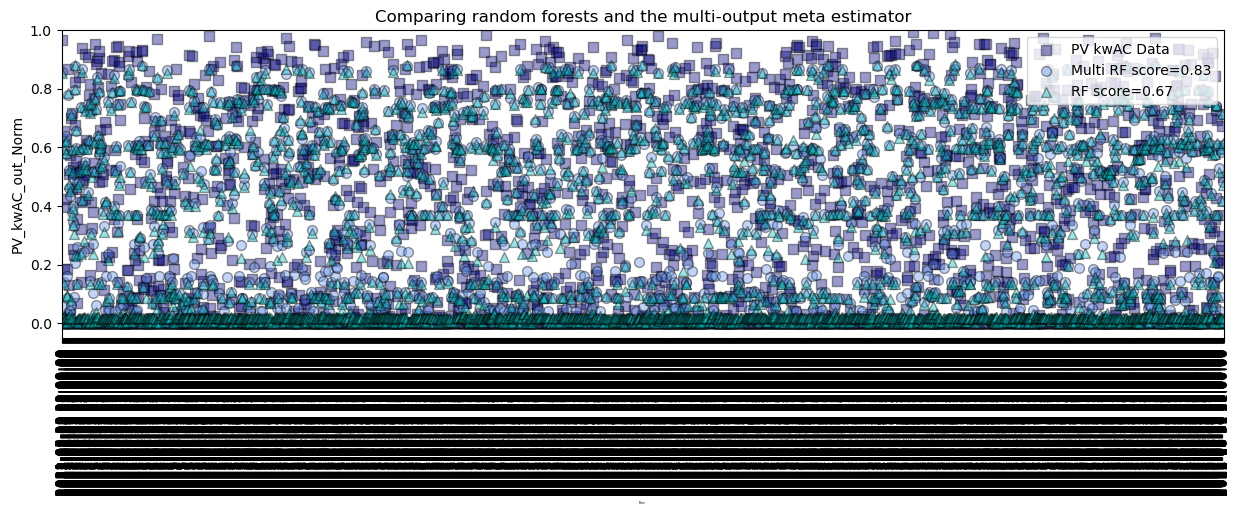

In [82]:
# Plot the results
plt.figure(figsize=(15, 4))
s = 50
a = 0.4
plt.scatter(
    y_test_select.index,
    y_test_select.loc[:, 'PV_kwAC_out_Norm'],
    edgecolor="k",
    c="navy",
    s=s,
    marker="s",
    alpha=a,
    label="PV kwAC Data",
)
plt.scatter(
    y_test_select.index,
    y_multirf[:, 1],
    edgecolor="k",
    c="cornflowerblue",
    s=s,
    alpha=a,
    label="Multi RF score=%.2f" % regr_multirf.score(X_test_select, y_test_select),
)
plt.scatter(
    y_test_select.index,
    y_rf[:, 1],
    edgecolor="k",
    c="c",
    s=s,
    marker="^",
    alpha=a,
    label="RF score=%.2f" % regr_rf.score(X_test_select, y_test_select),
)
plt.xlim([-1, 3504])
plt.ylim([-.05, 1])
plt.xlabel('Time', fontsize=2)
plt.xticks(rotation=90)
plt.ylabel('PV_kwAC_out_Norm')
plt.title('Comparing random forests and the multi-output meta estimator')
plt.legend()
plt.show()

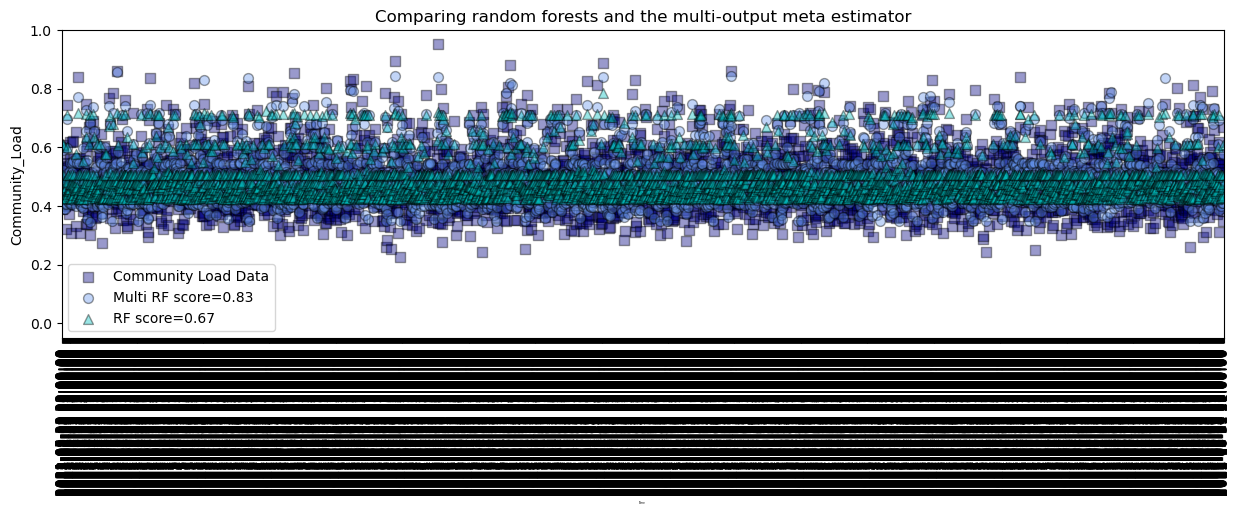

In [83]:
# Plot the results
plt.figure(figsize=(15, 4))
s = 50
a = 0.4
plt.scatter(
    y_test_select.index,
    y_test_select.loc[:, 'Community_Load'],
    edgecolor="k",
    c="navy",
    s=s,
    marker="s",
    alpha=a,
    label='Community Load Data',
)
plt.scatter(
    y_test_select.index,
    y_multirf[:, 2],
    edgecolor="k",
    c="cornflowerblue",
    s=s,
    alpha=a,
    label="Multi RF score=%.2f" % regr_multirf.score(X_test_select, y_test_select),
)
plt.scatter(
    y_test_select.index,
    y_rf[:, 2],
    edgecolor="k",
    c="c",
    s=s,
    marker="^",
    alpha=a,
    label="RF score=%.2f" % regr_rf.score(X_test_select, y_test_select),
)
plt.xlim([-1, 3504])
plt.ylim([-.05, 1])
plt.xlabel('Time', fontsize=2)
plt.xticks(rotation=90)
plt.ylabel('Community_Load')
plt.title('Comparing random forests and the multi-output meta estimator')
plt.legend()
plt.show()